本章では，日本語と英語の翻訳コーパスである京都フリー翻訳タスク (KFTT)を用い，ニューラル機械翻訳モデルを構築する．ニューラル機械翻訳モデルの構築には，fairseq，Hugging Face Transformers，OpenNMT-pyなどの既存のツールを活用せよ．
## knock90 データの準備
機械翻訳のデータセットをダウンロードせよ．訓練データ，開発データ，評価データを整形し，必要に応じてトークン化などの前処理を行うこと．ただし，この段階ではトークンの単位として形態素（日本語）および単語（英語）を採用せよ．

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# download KFTT data and unzip
!wget http://www.phontron.com/kftt/download/kftt-data-1.0.tar.gz
!tar -zxvf kftt-data-1.0.tar.gz

In [ ]:
# install mecab 
!apt install mecab libmecab-dev mecab-ipadic-utf8

In [ ]:
# install CRF++(実行に必要)
FILE_ID = '0B4y35FiV1wh7QVR6VXJ5dWExSTQ'
FILE_NAME = 'crfpp.tar.gz'
!wget 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O $FILE_NAME
!tar xvf crfpp.tar.gz
%cd CRF++-0.58
!./configure && make && make install && ldconfig
!pwd
%cd /content

In [5]:
# use macab to tokenize japanese data
!cat kftt-data-1.0/data/orig/kyoto-train.ja | mecab > train.mecab.ja
!cat kftt-data-1.0/data/orig/kyoto-dev.ja | mecab > dev.mecab.ja
!cat kftt-data-1.0/data/orig/kyoto-test.ja | mecab > test.mecab.ja

In [6]:
for src, dst in [
    ('train.mecab.ja', 'train.spacy.ja'),
    ('dev.mecab.ja', 'dev.spacy.ja'),
    ('test.mecab.ja', 'test.spacy.ja'),
]:
    with open(src) as f:
        lst = []
        tmp = []
        for x in f:
            x = x.strip()
            if x == 'EOS':
                lst.append(' '.join(tmp))   # 空白で区切られる
                tmp = []
            elif x != '':
                tmp.append(x.split('\t')[0])
    with open(dst, 'w') as f:
        for line in lst:
            print(line, file=f)

In [7]:
print('orignal data for ja:\n')
with open('/content/kftt-data-1.0/data/orig/kyoto-train.ja') as f1:
  data = f1.readlines()
  for line in data[:4]:
    print(line)
print('mecab data for ja:\n')
with open('train.mecab.ja') as f2:
  data = f2.readlines()
  for line in data[:4]:
    print(line)
print('space data for ja:\n')
with open('train.spacy.ja') as f:
  data = f.readlines()
  for line in data[:4]:
    print(line)

orignal data for ja:

雪舟（せっしゅう、1420年（応永27年）-1506年（永正3年））は号で、15世紀後半室町時代に活躍した水墨画家・禅僧で、画聖とも称えられる。

日本の水墨画を一変させた。

諱は「等楊（とうよう）」、もしくは「拙宗（せっしゅう）」と号した。

備中国に生まれ、京都・相国寺に入ってから周防国に移る。

mecab data for ja:

雪舟	名詞,固有名詞,人名,一般,*,*,雪舟,セッシュウ,セッシュー

（	記号,括弧開,*,*,*,*,（,（,（

せっしゅう	名詞,サ変接続,*,*,*,*,せっしゅう,セッシュウ,セッシュー

、	記号,読点,*,*,*,*,、,、,、

space data for ja:

雪舟 （ せっしゅう 、 1420 年 （ 応永 27 年 ） - 1506 年 （ 永 正 3 年 ） ） は 号 で 、 15 世紀 後半 室町 時代 に 活躍 し た 水墨 画家 ・ 禅僧 で 、 画聖 と も 称え られる 。

日本 の 水墨 画 を 一変 さ せ た 。

諱 は 「 等 楊 （ とう よう ） 」 、 もしくは 「 拙 宗 （ せっしゅう ） 」 と 号 し た 。

備中 国 に 生まれ 、 京都 ・ 相国寺 に 入っ て から 周防 国 に 移る 。



In [12]:
import re
import spacy
# tokenize data-en

nlp = spacy.load('en_core_web_sm')

for src, dst in [
    ('kftt-data-1.0/data/orig/kyoto-train.en', 'train.spacy.en'),
    ('kftt-data-1.0/data/orig/kyoto-dev.en', 'dev.spacy.en'),
    ('kftt-data-1.0/data/orig/kyoto-test.en', 'test.spacy.en'),   
]:
  with open(src) as f, open(dst, 'w') as g:
    for x in f:
      x = x.strip()
      x = re.sub(r'\s+', ' ', x)
      x = nlp.make_doc(x)
      x = ' '.join([doc.text for doc in x])
      print(x, file=g)


In [13]:
print('orignal data for en:\n')
with open('/content/kftt-data-1.0/data/orig/kyoto-train.en') as f1:
  data = f1.readlines()
  for line in data[:4]:
    print(line)
print('space data for en:\n')
with open('train.spacy.en') as f2:
  data = f2.readlines()
  for line in data[:4]:
    print(line)

orignal data for en:

Known as Sesshu (1420 - 1506), he was an ink painter and Zen monk active in the Muromachi period in the latter half of the 15th century, and was called a master painter.

He revolutionized the Japanese ink painting.

He was given the posthumous name "Toyo" or "Sesshu (拙宗)."

Born in Bicchu Province, he moved to Suo Province after entering SShokoku-ji Temple in Kyoto.

space data for en:

Known as Sesshu ( 1420 - 1506 ) , he was an ink painter and Zen monk active in the Muromachi period in the latter half of the 15th century , and was called a master painter .

He revolutionized the Japanese ink painting .

He was given the posthumous name " Toyo " or " Sesshu ( 拙宗 ) . "

Born in Bicchu Province , he moved to Suo Province after entering SShokoku - ji Temple in Kyoto .



In [ ]:
!pip install fairseq
# doc: https://github.com/facebookresearch/fairseq/tree/main/examples/translation

## knock91 機械翻訳モデルの訓練
90で準備したデータを用いて，ニューラル機械翻訳のモデルを学習せよ（ニューラルネットワークのモデルはTransformerやLSTMなど適当に選んでよい）．

In [15]:
# preprocess/binarize the data
# src:ja trg:en; preprocessed data is saved to data91
!fairseq-preprocess -s ja -t en \
    --trainpref train.spacy \
    --validpref dev.spacy \
    --destdir data91  \
    --thresholdsrc 5 \
    --thresholdtgt 5 \
    --workers 20
# runing time:3min28s
# tokenizer=None,bpe=None,cpu=False, criterion='cross_entropy',lr_scheduler='fixed',min_loss_scale=0.0001,optimizer=None,scoring='bleu', seed=1
# [ja] Dictionary: 49320 types
# [ja] train.spacy.ja: 440288 sents, 11412336 tokens, 1.0% replaced (by <unk>)
# [ja] dev.spacy.ja: 1166 sents, 26014 tokens, 1.04% replaced (by <unk>)
# [en] Dictionary: 61944 types
# [en] train.spacy.en: 440288 sents, 11763358 tokens, 2.68% replaced (by <unk>)
# [en] dev.spacy.en: 1166 sents, 25042 tokens, 3.95% replaced (by <unk>)

2022-07-23 09:55:37 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
2022-07-23 09:55:38 | INFO | fairseq_cli.preprocess | Namespace(aim_repo=None, aim_run_hash=None, align_suffix=None, alignfile=None, all_gather_list_size=16384, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='data91', dict_only=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_file=None, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, on_cpu_convert_precision=False, only_source=False, optimizer=None, padding_factor=8, plasma_path='/tmp/plasma', profile=False, 

In [16]:
# train a Transformer translation model
# CUDA_VISIBLE_DEVICE=0 # specify which GPU to use
# epochs=3
!fairseq-train data91 \
    --fp16 \
    --save-dir save91 \
    --max-epoch 3 \
    --update-freq 1 \
    --encoder-normalize-before --decoder-normalize-before \
    --arch transformer \
    --encoder-embed-dim 512 --encoder-ffn-embed-dim 1024 --encoder-attention-heads 4 --encoder-layers 4 \
    --decoder-embed-dim 512 --decoder-ffn-embed-dim 1024 --decoder-attention-heads 4 --decoder-layers 4 \
    --share-decoder-input-output-embed \
    --optimizer adam --adam-betas '(0.9, 0.999)' --clip-norm 1.0 \
    --lr 1e-3 --lr-scheduler inverse_sqrt --warmup-updates 2000 \
    --dropout 0.2 --weight-decay 0.0001 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --max-tokens 8000 > 91.log
# epoch 001: 100% 1812/1813 [08:17<00:00,  3.56it/s, loss=7.004, nll_loss=5.627, ppl=49.41, wps=24782, ups=3.63, wpb=6820.1, bsz=222.9, num_updates=1800, lr=0.0009, gnorm=0.68, clip=6, loss_scale=8, train_wall=27, gb_free=8.1, wall=495]
# epoch 002: 100% 1812/1813 [08:19<00:00,  3.50it/s, loss=5.837, nll_loss=4.281, ppl=19.44, wps=23867.5, ups=3.66, wpb=6515.8, bsz=237.1, num_updates=3600, lr=0.000745356, gnorm=0.529, clip=5, loss_scale=8, train_wall=27, gb_free=7.7, wall=1007]
# epoch 003: 100% 1812/1813 [08:18<00:00,  3.73it/s, loss=5.258, nll_loss=3.617, ppl=12.27, wps=24933.4, ups=3.58, wpb=6963.6, bsz=287, num_updates=5400, lr=0.000608581, gnorm=0.492, clip=3, loss_scale=8, train_wall=28, gb_free=7.8, wall=1517]
# runing time:26min2sec

epoch 001: 100% 1812/1813 [08:17<00:00,  3.56it/s, loss=7.004, nll_loss=5.627, ppl=49.41, wps=24782, ups=3.63, wpb=6820.1, bsz=222.9, num_updates=1800, lr=0.0009, gnorm=0.68, clip=6, loss_scale=8, train_wall=27, gb_free=8.1, wall=495]
epoch 001 | valid on 'valid' subset:   0% 0/8 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  12% 1/8 [00:00<00:00,  7.54it/s]
epoch 001 | valid on 'valid' subset:  38% 3/8 [00:00<00:00, 10.72it/s]
epoch 001 | valid on 'valid' subset:  62% 5/8 [00:00<00:00, 11.47it/s]
epoch 001 | valid on 'valid' subset:  88% 7/8 [00:00<00:00, 13.14it/s]
epoch 002: 100% 1812/1813 [08:19<00:00,  3.50it/s, loss=5.837, nll_loss=4.281, ppl=19.44, wps=23867.5, ups=3.66, wpb=6515.8, bsz=237.1, num_updates=3600, lr=0.000745356, gnorm=0.529, clip=5, loss_scale=8, train_wall=27, gb_free=7.7, wall=1007]
epoch 002 | valid on 'valid' subset:   0% 0/8 [00:00<?, ?it/s]
epoch 002 | valid on 'valid' subset:  12% 1/8 [00:00<00:00,  9.24it/s]
epoch 002 | valid on 'valid' subset:  38

## knock92 機械翻訳モデルの適用
91で学習したニューラル機械翻訳モデルを用い，与えられた（任意の）日本語の文を英語に翻訳するプログラムを実装せよ．

In [ ]:
!pip install tensorboardX

In [18]:
!fairseq-interactive data91 \
--path save91/checkpoint3.pt \
--buffer-size 1024 \
--batch-size 128 \
--beam 5 \
--lenpen 0.6 \
< test.spacy.ja | grep '^H' | cut -f3 > 92.en.out
# [ja] dictionary: 49320 types
# [en] dictionary: 55472 types
# Total time: 27.169 seconds; translation time: 16.299

2022-07-23 10:27:02 | INFO | fairseq_cli.interactive | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_plasma_view': False, 'plasma_path': '/tmp/plasma'}, 'common_eval': {'_na

In [ ]:
with open('92.en.out') as f:
  data = f.readlines()
  print(len(data))   # 1160
  for line in data[:9]:
    print(line)
    
# <unk>
# Dogen was a Zen monk in the early Kamakura period .
# He was the founder of the Soto sect .
# He was also called <unk> in his later years .
# In the same sect , he was called Koso .
# His posthumous name was <unk> and <unk> .
# It is generally called Dogen Zenji .
# It is said that in Japan , it spread manners and cleaning .
# There is a theory that he brought back to Japan first .

## knock93 BLEUスコアの計測
91で学習したニューラル機械翻訳モデルの品質を調べるため，評価データにおけるBLEUスコアを測定せよ.

In [20]:
!fairseq-score --sys 92.en.out --ref test.spacy.en > 93.bleu

In [21]:
with open('93.bleu') as f:
  data = f.readlines()
  print(len(data))   # 2
  for line in data[:9]:
    print(line)
    
# Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='92.en.out')
# BLEU4 = 19.65, 52.2/26.2/15.2/9.5 (BP=0.931, ratio=0.933, syslen=25794, reflen=27636)

2
Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='92.en.out')

BLEU4 = 19.65, 52.2/26.2/15.2/9.5 (BP=0.931, ratio=0.933, syslen=25794, reflen=27636)



In [ ]:
!pip install sacrebleu
# doc: https://github.com/mjpost/sacrebleu

In [23]:
# using your own refernce file
# pass the refer_file as a positional argument to sacrebleu :sacrebleu ref.detok.txt -i output.detok.txt -m bleu
# or redirect the system info STDIN: cat ouput.detok.txt | sacrebleu ref.detok.txt -m bleu
! cat 92.en.out | sacrebleu test.spacy.en -m bleu -f text
# BLEU|nrefs:1|case:mixed|eff:no|tok:13a|smooth:exp|version:2.1.0 = 19.7 49.1/24.6/14.3/8.9 (BP = 0.993 ratio = 0.993 hyp_len = 27547 ref_len = 27749)

sacreBLEU: That's 100 lines that end in a tokenized period ('.')
sacreBLEU: It looks like you forgot to detokenize your test data, which may hurt your score.
sacreBLEU: If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
BLEU|nrefs:1|case:mixed|eff:no|tok:13a|smooth:exp|version:2.1.0 = 19.7 49.1/24.6/14.3/8.9 (BP = 0.993 ratio = 0.993 hyp_len = 27547 ref_len = 27749)


## knock94 ビーム探索
91で学習したニューラル機械翻訳モデルで翻訳文をデコードする際に，ビーム探索を導入せよ．ビーム幅を1から100くらいまで適当に変化させながら，開発セット上のBLEUスコアの変化をプロットせよ．

In [ ]:
%%bash
for N in `seq 5 10`; do
  fairseq-interactive --path save91/checkpoint_best.pt --beam $N data91 < test.spacy.ja | grep '^H' | cut -f3 > 94.beam$N.out
  done


In [ ]:
%%bash
for N in `seq 5 10`; do
  fairseq-score --sys 94.beam$N.out --ref test.spacy.en | tee 94.beam$N.score
  done
# Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam5.out')
# BLEU4 = 17.96, 50.8/24.7/13.7/8.2 (BP=0.927, ratio=0.929, syslen=24311, reflen=26155)
# Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam6.out')
# BLEU4 = 17.81, 51.4/24.9/13.8/8.2 (BP=0.912, ratio=0.916, syslen=23955, reflen=26155)
# Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam7.out')
# BLEU4 = 17.71, 50.8/24.6/13.6/8.1 (BP=0.920, ratio=0.923, syslen=24133, reflen=26155)
# Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam8.out')
# BLEU4 = 17.96, 51.0/24.8/13.7/8.2 (BP=0.925, ratio=0.927, syslen=24258, reflen=26155)
# Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam9.out')
# BLEU4 = 17.93, 51.4/25.1/13.9/8.4 (BP=0.911, ratio=0.914, syslen=23915, reflen=26155)
# Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam10.out')
# BLEU4 = 18.08, 51.1/24.9/13.8/8.3 (BP=0.924, ratio=0.927, syslen=24234, reflen=26155)

In [ ]:
%%bash
for N in `seq 10 15`; do
  fairseq-interactive data91 \
  --path save91/checkpoint_best.pt \
  --beam $N \
  < test.spacy.ja | grep '^H' | cut -f3 > 94.beam$N.out
  done
# runing time:24min40sec

In [25]:
%%bash
for N in `seq 10 15`; do
  fairseq-score --sys 94.beam$N.out --ref test.spacy.en > 94.beam$N.score
  done

In [26]:
%%bash
for N in `seq 10 15`; do
  cat 94.beam$N.score
  done

# Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam10.out')
# BLEU4 = 20.27, 51.1/25.6/14.9/9.3 (BP=0.982, ratio=0.982, syslen=27145, reflen=27636)
# Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam11.out')
# BLEU4 = 20.22, 50.9/25.5/14.9/9.3 (BP=0.984, ratio=0.984, syslen=27201, reflen=27636)
# Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam12.out')
# BLEU4 = 20.20, 51.3/25.6/14.9/9.3 (BP=0.978, ratio=0.979, syslen=27044, reflen=27636)
# Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam13.out')
# BLEU4 = 20.26, 51.3/25.6/15.0/9.4 (BP=0.978, ratio=0.978, syslen=27035, reflen=27636)
# Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam14.out')
# BLEU4 = 20.27, 51.3/25.7/15.0/9.4 (BP=0.977, ratio=0.977, syslen=26995, reflen=27636)
# Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam15.out')
# BLEU4 = 20.32, 51.6/25.9/15.2/9.5 (BP=0.969, ratio=0.970, syslen=26801, reflen=27636)

Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam10.out')
BLEU4 = 20.27, 51.1/25.6/14.9/9.3 (BP=0.982, ratio=0.982, syslen=27145, reflen=27636)
Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam11.out')
BLEU4 = 20.22, 50.9/25.5/14.9/9.3 (BP=0.984, ratio=0.984, syslen=27201, reflen=27636)
Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam12.out')
BLEU4 = 20.20, 51.3/25.6/14.9/9.3 (BP=0.978, ratio=0.979, syslen=27044, reflen=27636)
Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam13.out')
BLEU4 = 20.26, 51.3/25.6/15.0/9.4 (BP=0.978, ratio=0.978, syslen=27035, reflen=27636)
Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='94.beam14.out')
BLEU4 = 20.27, 51.3/25.7/15.0/9.4 (BP=0.977, ratio=0.977, syslen=2

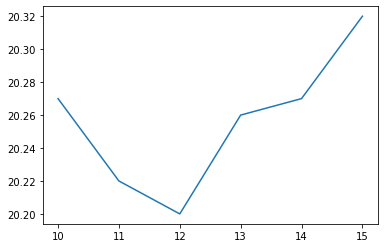

In [29]:
import matplotlib.pyplot as plt

def read_score(filename):
  with open(filename) as f:
    x = f.readlines()[1]
    x = re.search(r'(?<=BLEU4 = )\d*\.\d*(?=,)', x)
  return float(x.group())

xs = range(10, 16)
ys = [read_score(f'94.beam{x}.score') for x in xs]
plt.plot(xs, ys)
plt.show()

## knock95 サブワード化
トークンの単位を単語や形態素からサブワードに変更し，91-94の実験を再度実施せよ.
## 1．訓練データを用いて、源言語と目標言語それぞれのsentencepieceモデルを構築し、サブワード化

[参照記事](https://note.com/npaka/n/n90f97543ec4b)

[SentecePiece](https://github.com/google/sentencepiece)

言語を処理する時、テキストをまず「トークン」に分割して、それを「ベクトル表現」に変換する。
* 形態素解析して得た「単語」は利用上に問題点ある:

語彙数が膨大で、高頻度語彙のみに限定している。低頻度語彙が捨てられて未知語として扱われている。
* SentencePieceの手順:

まず、テキストを単語に分割し、各単語の頻度を求める。
次は、低頻度単語は1語彙として扱い、より短い語彙に分割する。
語彙数が事前に指定したサイズになるまで、分割を繰り返します。

## 2．91-94の実験を再度実施
* sentencepieceモデルを学習(教師なし学習)
* preprocessでバイナリデータにする
* 推論時のbeam_sizeを変えながら、BLUEスコアを計算し、可視化する 

In [ ]:
!pip install sentencepiece

In [31]:
import sentencepiece as spm
import re

# 学習の実行
spm.SentencePieceTrainer.Train(
    '--input=/content/kftt-data-1.0/data/orig/kyoto-train.ja --model_prefix=kyoto_ja --vocab_size=16000 --character_coverage=0.9995')

# 学習済み単語分割モデルを用いて日本語dataをsubword化
sp = spm.SentencePieceProcessor()
sp.Load('kyoto_ja.model')

for src, dst in [
  ('kftt-data-1.0/data/orig/kyoto-train.ja', 'train.sub.ja'),
  ('kftt-data-1.0/data/orig/kyoto-dev.ja', 'dev.sub.ja'),
  ('kftt-data-1.0/data/orig/kyoto-test.ja', 'test.sub.ja')
]:
  with open(src, 'r') as rf, open(dst, 'w') as wf:
    for x in rf:
      x = x.strip()
      x = re.sub(r'\s+', ' ', x)
      x = sp.encode_as_pieces(x)
      x = ' '.join(x)
      print(x, file=wf)

# runing time: 4min37sec

In [ ]:
# 英語をsubword化
!pip install subword-nmt

!subword-nmt learn-bpe -s 16000 < kftt-data-1.0/data/orig/kyoto-train.en > kyoto_en.codes
!subword-nmt apply-bpe -c kyoto_en.codes < kftt-data-1.0/data/orig/kyoto-train.en > train.sub.en
!subword-nmt apply-bpe -c kyoto_en.codes < kftt-data-1.0/data/orig/kyoto-dev.en > dev.sub.en
!subword-nmt apply-bpe -c kyoto_en.codes < kftt-data-1.0/data/orig/kyoto-test.en > test.sub.en

# runing time:1min56sec  
# vocab_size:16000

In [33]:
# binarize data
!fairseq-preprocess -s ja -t en\
    --trainpref train.sub \
    --validpref dev.sub \
    --testpref test.sub \
    --tokenizer space \
    --workers 20 \
    --thresholdsrc 3 \
    --thresholdtgt 3 \
    --task translation \
    --workers 20 \
    --destdir knock95_subwords_sp

# Namespace(aim_repo=None, aim_run_hash=None, align_suffix=None, alignfile=None, all_gather_list_size=16384, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='knock95_subwords_sp', dict_only=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_file=None, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, on_cpu_convert_precision=False, only_source=False, optimizer=None, padding_factor=8, plasma_path='/tmp/plasma', profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='ja', srcdict=None, suppress_crashes=False, target_lang='en', task='translation', tensorboard_logdir=None, testpref='test.sub', tgtdict=None, threshold_loss_scale=None, thresholdsrc=3, thresholdtgt=3, tokenizer='space', tpu=False, trainpref='train.sub', use_plasma_view=False, user_dir=None, validpref='dev.sub', wandb_project=None, workers=20)
# [ja] Dictionary: 17048 types
# [ja] train.sub.ja: 440288 sents, 10462018 tokens, 0.0147% replaced (by <unk>)
# [ja] Dictionary: 17048 types
# [ja] dev.sub.ja: 1166 sents, 24223 tokens, 0.0206% replaced (by <unk>)
# [ja] Dictionary: 17048 types
# [ja] test.sub.ja: 1160 sents, 26130 tokens, 0.0153% replaced (by <unk>)
# [en] Dictionary: 18656 types
# [en] train.sub.en: 440288 sents, 13280091 tokens, 0.022% replaced (by <unk>)
# [en] Dictionary: 18656 types
# [en] dev.sub.en: 1166 sents, 29011 tokens, 0.0103% replaced (by <unk>)
# [en] Dictionary: 18656 types
# [en] test.sub.en: 1160 sents, 31468 tokens, 0.0254% replaced (by <unk>)
# Wrote preprocessed data to knock95_subwords_sp

2022-07-23 11:07:49 | INFO | fairseq_cli.preprocess | Namespace(aim_repo=None, aim_run_hash=None, align_suffix=None, alignfile=None, all_gather_list_size=16384, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='knock95_subwords_sp', dict_only=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_file=None, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, on_cpu_convert_precision=False, only_source=False, optimizer=None, padding_factor=8, plasma_path='/tmp/plasma', profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='ja', srcdict

In [34]:
!fairseq-train knock95_subwords_sp \
    --fp16 \
    --save-dir save95 \
    --max-epoch 3 \
    --update-freq 1 \
    --encoder-normalize-before --decoder-normalize-before \
    --arch transformer \
    --encoder-embed-dim 512 --encoder-ffn-embed-dim 1024 --encoder-attention-heads 4 --encoder-layers 4 \
    --decoder-embed-dim 512 --decoder-ffn-embed-dim 1024 --decoder-attention-heads 4 --decoder-layers 4 \
    --share-decoder-input-output-embed \
    --optimizer adam --adam-betas '(0.9, 0.999)' --clip-norm 1.0 \
    --lr 1e-3 --lr-scheduler inverse_sqrt --warmup-updates 2000 \
    --dropout 0.2 --weight-decay 0.0001 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --max-tokens 8000 > 95.log
# runing time：17min
# epoch 001: 100% 1871/1872 [05:25<00:00,  5.56it/s, loss=7.651, nll_loss=6.528, ppl=92.29, wps=39280, ups=5.73, wpb=6859.2, bsz=229.9, num_updates=1800, lr=0.0009, gnorm=0.589, clip=3, loss_scale=8, train_wall=17, gb_free=11.5, wall=314]
# epoch 002: 100% 1871/1872 [05:29<00:00,  5.55it/s, loss=6.236, nll_loss=4.905, ppl=29.97, wps=40979.6, ups=5.68, wpb=7209.4, bsz=251.3, num_updates=3700, lr=0.000735215, gnorm=0.452, clip=1, loss_scale=8, train_wall=17, gb_free=11.5, wall=656]
# epoch 003: 100% 1871/1872 [05:30<00:00,  6.06it/s, loss=5.657, nll_loss=4.239, ppl=18.88, wps=39881.1, ups=5.64, wpb=7070.2, bsz=237.4, num_updates=5600, lr=0.000597614, gnorm=0.457, clip=2, loss_scale=8, train_wall=17, gb_free=11.3, wall=999]


epoch 001: 100% 1871/1872 [05:25<00:00,  5.56it/s, loss=7.651, nll_loss=6.528, ppl=92.29, wps=39280, ups=5.73, wpb=6859.2, bsz=229.9, num_updates=1800, lr=0.0009, gnorm=0.589, clip=3, loss_scale=8, train_wall=17, gb_free=11.5, wall=314]
epoch 001 | valid on 'valid' subset:   0% 0/9 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  11% 1/9 [00:00<00:00,  8.99it/s]
epoch 001 | valid on 'valid' subset:  33% 3/9 [00:00<00:00, 14.95it/s]
epoch 001 | valid on 'valid' subset:  67% 6/9 [00:00<00:00, 17.84it/s]
epoch 002: 100% 1871/1872 [05:29<00:00,  5.55it/s, loss=6.236, nll_loss=4.905, ppl=29.97, wps=40979.6, ups=5.68, wpb=7209.4, bsz=251.3, num_updates=3700, lr=0.000735215, gnorm=0.452, clip=1, loss_scale=8, train_wall=17, gb_free=11.5, wall=656]
epoch 002 | valid on 'valid' subset:   0% 0/9 [00:00<?, ?it/s]
epoch 002 | valid on 'valid' subset:  22% 2/9 [00:00<00:00, 15.30it/s]
epoch 002 | valid on 'valid' subset:  56% 5/9 [00:00<00:00, 18.93it/s]
epoch 002 | valid on 'valid' subset:  

In [48]:
!fairseq-interactive --path save95/checkpoint3.pt --beam 10 knock95_subwords_sp < test.spacy.ja \
| grep '^H' | cut -f3 |  sed -r 's/(@@ )|(@@ ?$)//g' > 95.beam10.out

# !fairseq-generate knock95_subwords_sp \
#   --path save95/checkpoint3.pt \
#   --beam 10 --batch-size 128 --remove-bpe < test.spacy.ja | grep '^H' | cut -f3 > 95.beam10.out

# [ja] dictionary: 17048 types
# [en] dictionary: 18656 types
# Total time: 379.424 seconds; translation time: 367.011

2022-07-23 12:10:49 | INFO | fairseq_cli.interactive | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_plasma_view': False, 'plasma_path': '/tmp/plasma'}, 'common_eval': {'_na

In [49]:
import spacy
nlp = spacy.load('en_core_web_sm')
def spacy_tokenize(src, dst):
    with open(src) as f, open(dst, 'w') as g:
        for x in f:
            x = x.strip()
            x = ' '.join([doc.text for doc in nlp(x)])
            print(x, file=g)
spacy_tokenize('95.beam10.out', '95.out.spacy')

In [52]:
!fairseq-score --sys 95.out.spacy --ref test.spacy.en

# Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='95.out.spacy')
# BLEU4 = 7.83, 25.3/10.2/5.2/2.8 (BP=1.000, ratio=1.602, syslen=44280, reflen=27636)

Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='95.out.spacy')
BLEU4 = 7.83, 25.3/10.2/5.2/2.8 (BP=1.000, ratio=1.602, syslen=44280, reflen=27636)


## knock96 学習過程の可視化
Tensorboardなどのツールを用い，ニューラル機械翻訳モデルが学習されていく過程を可視化せよ．可視化する項目としては，学習データにおける損失関数の値とBLEUスコア，開発データにおける損失関数の値とBLEUスコアなどを採用せよ．

In [ ]:
!fairseq-train knock95_subwords_sp \
    --fp16 \
    --tensorboard-logdir log96 \
    --save-dir save96 \
    --max-epoch 5 \
    --arch transformer --share-decoder-input-output-embed \
    --optimizer adam --clip-norm 1.0 \
    --lr 1e-3 --lr-scheduler inverse_sqrt --warmup-updates 2000 \
    --dropout 0.2 --weight-decay 0.0001 \
    --update-freq 1 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --max-tokens 8000 > 96.log

# knock97 ハイパー・パラメータの調整

ニューラルネットワークのモデルや，そのハイパーパラメータを変更しつつ，開発データにおけるBLEUスコアが最大となるモデルとハイパーパラメータを求めよ．

In [71]:
#学習
%%bash
# training with different dropout rate
for N in `seq 0.1 0.2 0.5`; do
  fairseq-train knock95_subwords_sp \
        --save-dir checkpoints/97.train.sub.dropout_$N \
        --arch transformer --share-decoder-input-output-embed \
        --optimizer adam --adam-betas '(0.9, 0.98)' --clip-norm 0.0 \
        --lr 5e-4 --lr-scheduler inverse_sqrt --warmup-updates 4000 \
        --dropout $N --weight-decay 0.0001 \
        --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
        --max-tokens 8000 \
        --max-epoch 3
done
# have run 1hr8min too heavy

Process is terminated.


In [ ]:
#推論
%%bash
for N in `seq 0.1 0.2 0.5` ; do
  fairseq-interactive knock95_subwords_sp \
    --path checkpoints/97.train.sub.dropout_$N/checkpoint_best.pt \
    < test.sub.ja | grep '^H' | cut -f3 | sed -r 's/(@@ )|(@@ ?$)//g' > out97/dropout_$N.out
  done

In [ ]:
#BLEUスコアを計算
%%bash
for N in `seq 0.1 0.2 0.5` ; do
    echo dropout=$N >> out97/score97.out 
    fairseq-score --sys out97/dropout_$N.out --ref test.spacy.en >> out97/score97.out
  done

# 98.ドメイン適応
Japanese-English Subtitle Corpus (JESC)やJParaCrawlなどの翻訳データを活用し，KFTTのテストデータの性能向上を試みよ．

In [ ]:
!wget http://www.kecl.ntt.co.jp/icl/lirg/jparacrawl/release/3.0/bitext/en-ja.tar.gz

In [ ]:
import tarfile

with tarfile.open('en-ja.tar.gz') as tar:
    for f in tar.getmembers():
        if f.name.endswith('txt'):
            text = tar.extractfile(f).read().decode('utf-8')
            break

data = text.splitlines()
data = [x.split('\t') for x in data]
data = [x for x in data if len(x) == 4]
data = [[x[3], x[2]] for x in data]

with open('jparacrawl.ja', 'w') as f, open('jparacrawl.en', 'w') as g:
    for j, e in data:
        print(j, file=f)
        print(e, file=g)


In [ ]:
with open('jparacrawl.ja') as f, open('train.jparacrawl.ja', 'w') as g:
    for x in f:
        x = x.strip()
        x = re.sub(r'\s+', ' ', x)
        x = sp.encode_as_pieces(x)
        x = ' '.join(x)
        print(x, file=g)

In [ ]:
# execute subword
!subword-nmt apply-bpe -c kyoto_en.codes < jparacrawl.en > train.jparacrawl.en

In [ ]:
!fairseq-preprocess -s ja -t en \
    --trainpref train.jparacrawl \
    --validpref dev.sub \
    --destdir data98  \
    --workers 20


In [ ]:
#学習
%%bash
# training with different learning rate
for N in `seq 0.001 0.0005`; do
  fairseq-train data98 \
        --fp16
        --save-dir checkpoints/train.jparacrawl.lr_$N \
        --arch transformer --share-decoder-input-output-embed \
        --optimizer adam --adam-betas '(0.9, 0.98)' --clip-norm 0.0 \
        --lr $N --lr-scheduler inverse_sqrt --warmup-updates 4000 \
        --dropout $N --weight-decay 0.0001 \
        --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
        --max-tokens 4096 \
        --max-epoch 5
  done

In [ ]:
#推論
%%bash
for N in `seq 0.001 0.0005` ; do
  fairseq-interactive data98 \
    --path checkpoints/train.jparacrawl.lr_$N/checkpoint_best.pt \
    < test.sub.ja | grep '^H' | cut -f3 | sed -r 's/(@@ )|(@@ ?$)//g' > out98/lr_$N.out
  done


In [ ]:
#BLEUスコアを計算
%%bash
for N in `seq 0.001 0.0005` ; do
    echo lr=$N >> out98/score98.out 
    fairseq-score --sys out98/lr_$N.out --ref test.spacy.en >> out98/score98.out
  done

# 99．翻訳サーバの構築
ユーザが翻訳したい文を入力すると，その翻訳結果がウェブブラウザ上で表示されるデモシステムを構築せよ．